In [34]:
import pickle as pkl
import pandas as pd
import numpy as np
from pathlib import Path

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from src import util_analysis 
from scipy import stats 
from copy import deepcopy
import re
from importlib import reload
import matplotlib 
from pprint import pprint
from matplotlib import container


In [35]:
matplotlib.rcParams.update({'font.size': 10})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['svg.fonttype'] = 'none'

fig_out_dir = Path("rebuttal_figs/figure_6")
fig_out_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
### Import pre-formated data 

results_dir = Path('data')

# diotic SWC 
diotic_results = pd.read_csv(results_dir / "experiment_1_df.csv")
diotic_results['experiment'] = 'Diotic'

# Popham SWC
popham_results = pd.read_pickle(results_dir / "df_for_stats_2024_SWC_popham_conditions_humans_N-90_models_v10_w_control_archs.pdpkl")
popham_results.loc[popham_results.group.str.contains("Human"), 'model'] = popham_results.loc[popham_results.group.str.contains("Human"), 'group']
popham_results['snr'] = 0 # add snr column to match diotic_results
popham_conds_to_keep = ['Harmonic_target_Harmonic_distractor',
                        'Harmonic_target_No Distractor_distractor',
                        'Inharmonic_target_Inharmonic_distractor',
                        'Inharmonic_target_No Distractor_distractor',
                        'Whispered_target_No Distractor_distractor',
                        'Whispered_target_Whispered_distractor']

popham_results = popham_results[popham_results['background_condition'].isin(popham_conds_to_keep)].reset_index(drop=True)
popham_results['experiment'] = 'Harmonicity'

# threshold results 
threshold_results = pd.read_pickle(results_dir / "df_for_stats_and_summary_2024_thresholds_humans_N-33_models_v10_w_control_archs.pdpkl")
threshold_results['background_condition'] = threshold_results['azim_delta'].astype('str') + ' azim delta ' + threshold_results['elev_delta'].astype('str') + ' elev delta' 
threshold_results['experiment'] = 'Threshold'
threshold_results.rename(columns={'accuracy_sem': 'acc_sem', 'confusions_sem': 'conf_sem'}, inplace=True)

# Spotlight results 
spotlight_results = pd.read_pickle(results_dir / "df_for_stats_and_summary_2024_spotlight_humans_N-28_models_v10_w_control_archs.pdpkl")
spotlight_results['snr'] = 0 
spotlight_results['background_condition'] = spotlight_results['target_azim'].astype('str') + ' target azim ' + spotlight_results['azim_delta'].astype('str') + ' azim delta'
spotlight_results['experiment'] = 'Spotlight'
spotlight_results.rename(columns={'accuracy_sem': 'acc_sem', 'confusions_sem': 'conf_sem'}, inplace=True)


In [37]:
combined_results = pd.concat([diotic_results, popham_results, threshold_results, spotlight_results], axis=0)
## update model names for comparison 

combined_results.loc[combined_results['model'].str.contains("early"), 'model'] = 'Early-only'
combined_results.loc[combined_results['model'].str.contains("late"), 'model'] = 'Late-only'
combined_results.loc[combined_results['model'].str.contains("control"), 'model'] = 'Baseline CNN'

combined_results['model'] = combined_results['model'].apply(util_analysis.get_model_name)


In [38]:
combined_results.model.value_counts()

model
Feature-gain alt v1     100
Feature-gain alt v9     100
Feature-gain alt v10    100
Feature-gain alt v12    100
Feature-gain alt v2     100
Feature-gain alt v4     100
Feature-gain alt v6     100
Feature-gain alt v7     100
Feature-gain alt v8     100
Baseline CNN            100
Feature-gain main       100
Early-only              100
Late-only               100
Human (N=195)            56
Human (N=33)             30
Humans (N=28)             8
Humans (N = 90)           6
Name: count, dtype: int64

### Load in norm before gain model

In [ ]:
results_dir = Path('data')
outfile = results_dir / 'norm_then_gain_model_summary_all_experiments.csv'
norm_then_gain_df = pd.read_csv(outfile)


In [40]:
combined_results = pd.concat([combined_results, norm_then_gain_df], ignore_index=True, axis=0)

In [41]:
combined_results.model.value_counts()

model
Feature-gain alt v1       100
Feature-gain alt v10      100
Feature-gain main         100
Feature-gain alt v12      100
Feature-gain alt v2       100
Feature-gain alt v4       100
Feature-gain alt v6       100
Feature-gain alt v7       100
Feature-gain alt v8       100
Feature-gain alt v9       100
Norm before gain model    100
Early-only                100
Late-only                 100
Baseline CNN              100
Human (N=195)              56
Human (N=33)               30
Humans (N=28)               8
Humans (N = 90)             6
Name: count, dtype: int64

## Prep for plots

In [42]:
combined_results['snr_condition_str'] = combined_results['snr'].astype(str) + ' dB ' + combined_results['background_condition']
human_results = combined_results[combined_results.group.str.contains('Human')]
human_results = human_results.sort_values(['snr', 'background_condition'])

model_list = [model for model in combined_results.model.unique() if 'Human' not in model]


model_sim_records = []

for ix, model in enumerate(model_list):

    model_results = combined_results[combined_results.model == model]
    model_results = model_results.sort_values(['snr', 'background_condition'])

    ## Add stats 
    r, p = stats.pearsonr(human_results.accuracy,  model_results.accuracy)
    # spearman_brown_r = r / np.sqrt(main_model_rho_acc)
    acc_r = r ** 2 
    # add to dict 
    acc_rmse = np.sqrt(np.mean((human_results.accuracy.values - model_results.accuracy.values)**2))

    # conf errors
    r, p = stats.pearsonr(human_results.confusions, model_results.confusions)
    conf_r = r ** 2
    conf_rmse = np.sqrt(np.mean((human_results.confusions.values - model_results.confusions.values)**2))

    record = {'model': model, 'acc_r': acc_r, 'acc_rmse': acc_rmse, 'conf_r': conf_r, 'conf_rmse': conf_rmse}
    model_sim_records.append(record)


In [43]:
model_sim_df = pd.DataFrame.from_records(model_sim_records)

In [47]:
from importlib import reload
import src.util_analysis as util_analysis
reload(util_analysis)
from src.util_analysis import bootstrap_sign_test_summary, sign_test


# run sign test per alternate model 
fba_model_r_acc_dist = model_sim_df.loc[model_sim_df.model.str.contains("main|gain"), "acc_r"].values
fba_model_r_conf_dist = model_sim_df.loc[model_sim_df.model.str.contains("main|gain"), "conf_r"].values

GLOBAL_MODEL_ORDER_LIST = ["Early-only", "Late-only", "Baseline CNN", "Norm before gain model"]

models_to_test = GLOBAL_MODEL_ORDER_LIST
 
for model in models_to_test:
    y_acc = model_sim_df.loc[model_sim_df.model == model, "acc_r"].values
    stats_result = sign_test(fba_model_r_acc_dist, mu0=y_acc)
    print(f"Feature-gain v {model}, Pearson's r^2 accuracy sign test stat={stats_result[0]} p={stats_result[1]:.5f}")
    y_conf = model_sim_df.loc[model_sim_df.model == model, "conf_r"].values
    stats_result = sign_test(fba_model_r_conf_dist, mu0=y_conf)
    print(f"Feature-gain v {model}, Pearson's r^2 confusions sign test stat={stats_result[0]} p={stats_result[1]:.5f}")
    print("")   

fba_model_r_acc_dist = model_sim_df.loc[model_sim_df.model.str.contains("main|gain"), "acc_rmse"].values
fba_model_r_conf_dist = model_sim_df.loc[model_sim_df.model.str.contains("main|gain"), "conf_rmse"].values

for model in models_to_test:
    y_acc = model_sim_df.loc[model_sim_df.model == model, "acc_rmse"].values
    stats_result = sign_test(fba_model_r_acc_dist, mu0=y_acc)
    print(f"Feature-gain v {model}, RMSE accuracy sign test stat={stats_result[0]} p={stats_result[1]:.5f}")
    y_conf = model_sim_df.loc[model_sim_df.model == model, "conf_rmse"].values
    stats_result = sign_test(fba_model_r_conf_dist, mu0=y_conf)
    print(f"Feature-gain v {model}, RMSE confusions sign test stat={stats_result[0]} p={stats_result[1]:.5f}")
    print("")   


Feature-gain v Early-only, Pearson's r^2 accuracy sign test stat=4.5 p=0.01172
Feature-gain v Early-only, Pearson's r^2 confusions sign test stat=-5.5 p=0.00098

Feature-gain v Late-only, Pearson's r^2 accuracy sign test stat=5.5 p=0.00098
Feature-gain v Late-only, Pearson's r^2 confusions sign test stat=5.5 p=0.00098

Feature-gain v Baseline CNN, Pearson's r^2 accuracy sign test stat=4.5 p=0.01172
Feature-gain v Baseline CNN, Pearson's r^2 confusions sign test stat=2.5 p=0.22656

Feature-gain v Norm before gain model, Pearson's r^2 accuracy sign test stat=5.0 p=0.00098
Feature-gain v Norm before gain model, Pearson's r^2 confusions sign test stat=0.0 p=1.00000

Feature-gain v Early-only, RMSE accuracy sign test stat=-4.5 p=0.01172
Feature-gain v Early-only, RMSE confusions sign test stat=5.5 p=0.00098

Feature-gain v Late-only, RMSE accuracy sign test stat=-5.5 p=0.00098
Feature-gain v Late-only, RMSE confusions sign test stat=-5.5 p=0.00098

Feature-gain v Baseline CNN, RMSE accuracy

In [48]:
### Set up color palette 

# add colors for diotic experimental conditions 
hue_order = ['clean', '1-talker',  '2-talker',  '4-talker', 'babble'] # 'noise',  'music', 'natural scene']
palette={}
palette['clean'] = 'k'

# set speech color gradient 
speech_palette = sns.color_palette("RdPu_r")
speech_order = hue_order[1:][::-1]

for ix, group in enumerate(speech_order):
    palette[group] = speech_palette[ix]

# add colors for noise conditions 
noise_order = ['noise',  'music', 'natural scene']
noise_palette = sns.color_palette("YlOrBr_r", n_colors=6)
noise_order = noise_order[::-1]

for ix, group in enumerate(noise_order):
    palette[group] = noise_palette[ix]

# add same and different sex color palette 
hue_order = ['Different', 'Same']
sex_palette = dict(zip(hue_order, sns.color_palette(palette='colorblind', n_colors=10, as_cmap=False)))
palette['Same'] = sex_palette['Same']
palette['Different'] = 'tab:cyan'
palette['English'] = 'tab:pink'
palette['Mandarin'] = 'seagreen'

# add popham conditions 
for cond in popham_conds_to_keep: 
    if 'No Distractor' in cond:
        palette[cond] = 'k'
    else:
        palette[cond] = 'b'

# add threshold conditions
threshold_conditions = threshold_results.background_condition.unique()
for cond in threshold_conditions:
    if '0 azim delta' in cond:
        # is elevation delta condition 
        palette[cond] = 'tab:blue'
    if 'delta 0 elev delta' in cond:
        palette[cond] = 'tab:orange'
# will make colors for confusions, where popham distractor reports are red 

# add colors for spotlight conditions
spotlight_conditions = spotlight_results.background_condition.unique()
spotlight_cmap = sns.color_palette('tab10', n_colors=8)

for cond in spotlight_conditions:
    if cond.startswith('0 target azim'):
        # is elevation delta condition 
        palette[cond] = spotlight_cmap[7]
    elif cond.startswith('90 target azim'):
        palette[cond] = spotlight_cmap[4]

confusion_palette = {k:v for k, v in palette.items()}
# add popham conditions 
for cond in popham_conds_to_keep: 
    if 'No Distractor' in cond:
        confusion_palette[cond] = 'k'
    else:
        confusion_palette[cond] = 'r'


In [49]:
def pearsons_r(vec_a, vec_b):
    """
    Calculate Pearson's r correlation coefficient between two vectors.
    """
    n = len(vec_a)
    mean_a = np.mean(vec_a)
    mean_b = np.mean(vec_b)
    ss_a = np.sum((vec_a - mean_a) ** 2)
    ss_b = np.sum((vec_b - mean_b) ** 2)
    cov_ab = np.sum((vec_a - mean_a) * (vec_b - mean_b))
    r = cov_ab / np.sqrt(ss_a * ss_b)
    return r

In [50]:
model_list = [model for model in combined_results.model.unique() if ('Human' not in model) and ('50Hz' not in model)]
model_list

['Feature-gain alt v1',
 'Feature-gain alt v10',
 'Feature-gain alt v12',
 'Feature-gain alt v2',
 'Feature-gain alt v4',
 'Feature-gain alt v6',
 'Feature-gain alt v7',
 'Feature-gain alt v8',
 'Feature-gain alt v9',
 'Feature-gain main',
 'Early-only',
 'Late-only',
 'Baseline CNN',
 'Norm before gain model']

# Plot aggrigate summary 

## Plot bar chart, pooling accuracy and confusions

### Run sign test on pooled similarity scores (pool hits and confusions)

In [51]:
pooled_results = combined_results.melt(id_vars=['snr', 'background_condition', 'model'], value_vars=['accuracy', 'confusions'], var_name='metric', value_name='measure')
pooled_results['condition_str'] = pooled_results['snr'].astype(str) + ' dB ' + pooled_results['background_condition'] + ' ' + pooled_results['metric']
# drop confusions for 

human_results = pooled_results[pooled_results.model.str.contains('Human')]
human_results = human_results.sort_values('condition_str')
model_list = [model for model in pooled_results.model.unique() if 'Human' not in model]

model_sim_records_pooled = []

for ix, model in enumerate(model_list):
    model_results = pooled_results[pooled_results.model == model]
    model_results = model_results.sort_values('condition_str')

    ## Get Pearson's r ^ 2  and RMSE 
    r, p = stats.pearsonr(human_results.measure,  model_results.measure)
    r2 = r ** 2
    rmse = np.sqrt(np.mean((human_results.measure.values - model_results.measure.values)**2))
    # add to dict
    record = {'model': model, 'r2': r2, 'rmse': rmse}
    model_sim_records_pooled.append(record)
model_sim_df_pooled = pd.DataFrame.from_records(model_sim_records_pooled)
model_sim_df_pooled

,model,r2,rmse
0,Feature-gain alt v1,0.956452,0.097702
1,Feature-gain alt v10,0.923123,0.115523
2,Feature-gain alt v12,0.941203,0.108784
3,Feature-gain alt v2,0.960421,0.081236
4,Feature-gain alt v4,0.951037,0.103720
5,Feature-gain alt v6,0.958537,0.092331
6,Feature-gain alt v7,0.955893,0.078094
7,Feature-gain alt v8,0.947803,0.094366
8,Feature-gain alt v9,0.954086,0.094552
9,Feature-gain main,0.964026,0.074064


In [60]:
## Run sign test with bootstrap confidence intervals
from importlib import reload
reload(util_analysis)

from src.util_analysis import bootstrap_sign_test_summary
sign_test_dict = []

fba_model_r_dist = model_sim_df_pooled.loc[model_sim_df_pooled.model.str.contains("main|alt"), "r2"].values
fba_model_rmse_dist = model_sim_df_pooled.loc[model_sim_df_pooled.model.str.contains("main|alt"), "rmse"].values

comparison_r2 = {
    model: model_sim_df_pooled.loc[model_sim_df_pooled.model == model, "r2"].values
    for model in GLOBAL_MODEL_ORDER_LIST
}
comparison_rmse = {
    model: model_sim_df_pooled.loc[model_sim_df_pooled.model == model, "rmse"].values
    for model in GLOBAL_MODEL_ORDER_LIST
}

bootstrap_kwargs = dict(n_bootstrap=1000, random_state=42)

r2_bootstrap_results = bootstrap_sign_test_summary(
    baseline_values=fba_model_r_dist,
    comparison_values=comparison_r2,
    **bootstrap_kwargs,
)
rmse_bootstrap_results = bootstrap_sign_test_summary(
    baseline_values=fba_model_rmse_dist,
    comparison_values=comparison_rmse,
    **bootstrap_kwargs,
)

for model in GLOBAL_MODEL_ORDER_LIST:
    r2_summary = r2_bootstrap_results[model]
    rmse_summary = rmse_bootstrap_results[model]

    print(
        f"Feature-gain v {model}, Pearson's r^2 sign test stat={r2_summary['sign_test_stat']:.1f} "
        f"p={r2_summary['sign_test_p']:.5f}, diff of mean={r2_summary['diff_mean']:.5f} "
        f"(95% CI [{r2_summary['boot_ci_low']:.5f}, {r2_summary['boot_ci_high']:.5f}])"
    )
    print(
        f"Feature-gain v {model}, RMSE sign test stat={rmse_summary['sign_test_stat']:.1f} "
        f"p={rmse_summary['sign_test_p']:.5f}, diff of mean={rmse_summary['diff_mean']:.5f} "
        f"(95% CI [{rmse_summary['boot_ci_low']:.5f}, {rmse_summary['boot_ci_high']:.5f}])"
    )
    print("")

    record = {
        'model': model,
        'r2_diff': r2_summary['diff_mean'],
        'r2_sign_test_stat': r2_summary['sign_test_stat'],
        'r2_n_pos': r2_summary['n_pos'],
        'r2_n_neg': r2_summary['n_neg'],
        'r2_n_total': r2_summary['n_total'],
        'r2_sign_test_p': r2_summary['sign_test_p'],
        'r2_diff_of_mean': r2_summary['diff_mean'],
        'r2_diff_ci_low': r2_summary['boot_ci_low'],
        'r2_diff_ci_high': r2_summary['boot_ci_high'],
        'rmse_diff': rmse_summary['diff_mean'],
        'rmse_sign_test_stat': rmse_summary['sign_test_stat'],
        'rmse_n_pos': rmse_summary['n_pos'],
        'rmse_n_neg': rmse_summary['n_neg'],
        'rmse_n_total': rmse_summary['n_total'],
        'rmse_sign_test_p': rmse_summary['sign_test_p'],
        'rmse_diff_of_mean': rmse_summary['diff_mean'],
        'rmse_diff_ci_low': rmse_summary['boot_ci_low'],
        'rmse_diff_ci_high': rmse_summary['boot_ci_high'],
    }
    sign_test_dict.append(record)

sign_test_df = pd.DataFrame.from_records(sign_test_dict)
sign_test_bootstrap_r2 = r2_bootstrap_results
sign_test_bootstrap_rmse = rmse_bootstrap_results


Feature-gain v Early-only, Pearson's r^2 sign test stat=5.0 p=0.00195, diff of mean=0.03552 (95% CI [0.02763, 0.04149])
Feature-gain v Early-only, RMSE sign test stat=-5.0 p=0.00195, diff of mean=-0.03974 (95% CI [-0.04759, -0.03177])

Feature-gain v Late-only, Pearson's r^2 sign test stat=5.0 p=0.00195, diff of mean=0.50652 (95% CI [0.49835, 0.51255])
Feature-gain v Late-only, RMSE sign test stat=-5.0 p=0.00195, diff of mean=-0.12504 (95% CI [-0.13300, -0.11766])

Feature-gain v Baseline CNN, Pearson's r^2 sign test stat=5.0 p=0.00195, diff of mean=0.09297 (95% CI [0.08514, 0.09881])
Feature-gain v Baseline CNN, RMSE sign test stat=-5.0 p=0.00195, diff of mean=-0.07045 (95% CI [-0.07789, -0.06290])

Feature-gain v Norm before gain model, Pearson's r^2 sign test stat=5.0 p=0.00195, diff of mean=0.07704 (95% CI [0.06974, 0.08292])
Feature-gain v Norm before gain model, RMSE sign test stat=-5.0 p=0.00195, diff of mean=-0.07833 (95% CI [-0.08615, -0.07069])



In [62]:
sign_test_df

,model,r2_diff,r2_sign_test_stat,r2_n_pos,r2_n_neg,r2_n_total,r2_sign_test_p,r2_diff_of_mean,r2_diff_ci_low,r2_diff_ci_high,rmse_diff,rmse_sign_test_stat,rmse_n_pos,rmse_n_neg,rmse_n_total,rmse_sign_test_p,rmse_diff_of_mean,rmse_diff_ci_low,rmse_diff_ci_high
0,Early-only,0.035522,5.0,10,0,10,0.001953,0.035522,0.027625,0.041495,-0.039738,-5.0,0,10,10,0.001953,-0.039738,-0.047594,-0.031772
1,Late-only,0.506522,5.0,10,0,10,0.001953,0.506522,0.498353,0.512554,-0.125042,-5.0,0,10,10,0.001953,-0.125042,-0.132996,-0.117659
2,Baseline CNN,0.092972,5.0,10,0,10,0.001953,0.092972,0.085141,0.098812,-0.070451,-5.0,0,10,10,0.001953,-0.070451,-0.077891,-0.062902
3,Norm before gain model,0.077038,5.0,10,0,10,0.001953,0.077038,0.069735,0.082916,-0.078333,-5.0,0,10,10,0.001953,-0.078333,-0.086155,-0.070691


## Bootstrap confidence intervals for errorbars in plot

This takes a few minutes

In [18]:
import os
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm.auto import tqdm, trange

np.random.seed(0)
data_for_barplot = combined_results[~combined_results.model.str.contains('alt')].copy()
data_for_barplot.loc[data_for_barplot['group'].str.contains("Human"), 'group'] = 'Human'  


melted_for_errbars = pd.melt(data_for_barplot, id_vars=['snr', 'background_condition', 'group'], value_vars=['accuracy', 'confusions'], var_name='metric', value_name='measure').reset_index(drop=True)
melted_for_errbars['condition_string'] = melted_for_errbars['snr'].astype(str) + ' dB ' + melted_for_errbars['background_condition'] + ' ' + melted_for_errbars['metric']


melted_for_errbars = melted_for_errbars.sort_values(['condition_string'])

model_list = [model for model in melted_for_errbars.group.unique() if 'Human' not in model]

unique_conds = melted_for_errbars.condition_string.unique()
n_conditions = melted_for_errbars.condition_string.nunique()

model_agg_sim_records = []

n_boots = 1000

full_human_measure = melted_for_errbars[melted_for_errbars.group == 'Human'].sort_values(['condition_string'])

def bootstrap_stats(model, full_human_measure_df, melted_df, unique_conds, n_conditions, n_boots=1000):
    model_measure = melted_df[melted_df.group == model].sort_values(['condition_string'])
    full_human_measure = full_human_measure_df.sort_values(['condition_string'])

    r, _ = stats.pearsonr(full_human_measure.measure, model_measure.measure)
    r2_full = r ** 2
    rmse_full = np.sqrt(np.mean((full_human_measure.measure.values - model_measure.measure.values) ** 2))
    rho_full = stats.spearmanr(full_human_measure.measure, model_measure.measure).statistic

    r_boots = np.zeros(n_boots)
    rmse_boots = np.zeros(n_boots)
    rho_boots = np.zeros(n_boots)

    for ix in range(n_boots):
        conditions_to_sample = np.random.choice(unique_conds, size=n_conditions, replace=True)

        human_sample = np.array([
            full_human_measure.loc[full_human_measure.condition_string == cond, "measure"].item()
            for cond in conditions_to_sample
        ])
        model_sample = np.array([
            model_measure.loc[model_measure.condition_string == cond, "measure"].item()
            for cond in conditions_to_sample
        ])

        r_boot, _ = stats.pearsonr(human_sample, model_sample)
        r_boots[ix] = r_boot ** 2
        rmse_boots[ix] = np.sqrt(np.mean((human_sample - model_sample) ** 2))
        rho_boots[ix] = stats.spearmanr(human_sample, model_sample).statistic
        

    r_ci = np.percentile(r_boots, [2.5, 97.5])
    rmse_ci = np.percentile(rmse_boots, [2.5, 97.5])
    rho_ci = np.percentile(rho_boots, [2.5, 97.5])
    
    return {
        'group': model,
        'r2': r2_full,
        'r2_ci': r_ci,
        'rmse': rmse_full,
        'rmse_ci': rmse_ci,
        'rho': rho_full,
        'rho_ci': rho_ci
    }

# Parallel execution
model_agg_sim_records = []
# # get number of processors
n_processors = os.cpu_count()

with ProcessPoolExecutor(max_workers=n_processors) as executor:
    futures = {
        executor.submit(
            bootstrap_stats, model, full_human_measure, melted_for_errbars, unique_conds, n_conditions, n_boots
        ): model
        for model in model_list
    }

    for future in tqdm(as_completed(futures), total=len(model_list)):
        model_agg_sim_records.append(future.result())

model_agg_sim_df = pd.DataFrame.from_records(model_agg_sim_records)


  0%|          | 0/5 [00:00<?, ?it/s]

In [19]:
model_agg_sim_df

,group,r2,r2_ci,rmse,rmse_ci,rho,rho_ci
0,Baseline CNN,0.858287,"[0.8315760797753193, 0.884423445194932]",0.164488,"[0.1489822004716401, 0.17969000433487273]",0.951197,"[0.9306891498007787, 0.9624925799528005]"
1,Early-only,0.915736,"[0.8995505544848419, 0.9329683378328679]",0.133775,"[0.12117182407337851, 0.14624454400062156]",0.969750,"[0.9570072375357074, 0.9751696564400139]"
2,Norm before gain model,0.874220,"[0.8349834761149363, 0.9123080844651349]",0.172370,"[0.15392206852084472, 0.19054198124387037]",0.962817,"[0.9482735377503324, 0.9716220163108178]"
3,Late-only,0.444736,"[0.3431870832861372, 0.5404317194118745]",0.219079,"[0.20273902738095168, 0.23703422226228216]",0.719892,"[0.6312777415514227, 0.791211171711222]"
4,Feature-gain Model,0.964026,"[0.9543869241764615, 0.9728190994338544]",0.074064,"[0.06586728613138346, 0.0820400980770086]",0.973949,"[0.9598388834049548, 0.9808907267339642]"


In [20]:
def annot_stat(star, x1, x2, y, h, col='k', ax=None, lw=1.5):
    ax = plt.gca() if ax is None else ax
    ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=lw, c=col)
    ax.text((x1+x2)*.5, y+h, star, ha='center', va='bottom', color=col)


def draw_stats_bar(ax, x1, x2, y, h, text, th=0.025, lw=1.5, col='k', fontsize=10, text_gap=0.02):
    # Calculate the position of the text
    text_x = (x1 + x2) * 0.5
    text_y = y + th
    
    # Calculate the gap around the text
    gap_half_width = text_gap * len(text) # * (x2 - x1) * 0.5
    
    # Draw the left part of the bar
    ax.plot([x1, x1, text_x - gap_half_width], [y, y + h, y + h], lw=lw, c=col)
    
    # Draw the right part of the bar
    ax.plot([text_x + gap_half_width, x2, x2], [y + h, y + h, y], lw=lw, c=col)
    
    # Draw the text in the middle of the bar
    ax.text(text_x, y-0.002, text, ha='center', va='center', color=col, fontsize=fontsize)
    

def get_star(p_val):
    if p_val < 0.05:
        text = "*"
    if p_val < 0.01:
        text = "**"
    if p_val < 0.001:
        text = "***"
    if p_val < 0.0001:
        text = "****"
    return text

In [21]:
from copy import deepcopy
to_plot = model_agg_sim_df.copy()

model_order = deepcopy(util_analysis.model_name_order)

to_plot.sort_values('group', key=lambda x: x.map({model: i for i, model in enumerate(model_order)}), inplace=True)

model_order[0] = "Feature-gain\nModel"
to_plot['group'].replace("Feature-gain Model", "Feature-gain\nModel", inplace=True)

x_vals = {model:ix for ix, model in enumerate(model_order)}
to_plot

/tmp/ipykernel_461392/2086919521.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to_plot['group'].replace("Feature-gain Model", "Feature-gain\nModel", inplace=True)


,group,r2,r2_ci,rmse,rmse_ci,rho,rho_ci
4,Feature-gain\nModel,0.964026,"[0.9543869241764615, 0.9728190994338544]",0.074064,"[0.06586728613138346, 0.0820400980770086]",0.973949,"[0.9598388834049548, 0.9808907267339642]"
0,Baseline CNN,0.858287,"[0.8315760797753193, 0.884423445194932]",0.164488,"[0.1489822004716401, 0.17969000433487273]",0.951197,"[0.9306891498007787, 0.9624925799528005]"
1,Early-only,0.915736,"[0.8995505544848419, 0.9329683378328679]",0.133775,"[0.12117182407337851, 0.14624454400062156]",0.969750,"[0.9570072375357074, 0.9751696564400139]"
3,Late-only,0.444736,"[0.3431870832861372, 0.5404317194118745]",0.219079,"[0.20273902738095168, 0.23703422226228216]",0.719892,"[0.6312777415514227, 0.791211171711222]"
2,Norm before gain model,0.874220,"[0.8349834761149363, 0.9123080844651349]",0.172370,"[0.15392206852084472, 0.19054198124387037]",0.962817,"[0.9482735377503324, 0.9716220163108178]"


## Plot figure 6b.

In [22]:
from importlib import reload

/tmp/ipykernel_461392/3212667061.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  to_plot['group'].replace("Feature-gain Model", "Feature-gain\nModel", inplace=True)


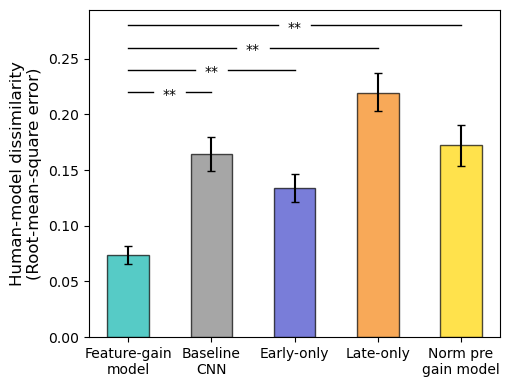

In [23]:
reload(util_analysis)
to_plot = model_agg_sim_df.copy()
## add bar plot 
aspect = 4.25
fontsize = 10

fig, ax = plt.subplots(figsize=(aspect*1.25, aspect))


model_order = deepcopy(util_analysis.model_name_order)
model_colors = deepcopy(util_analysis.model_color_dict)

to_plot.sort_values('group', key=lambda x: x.map({model: i for i, model in enumerate(model_order)}), inplace=True)
model_order[0] = "Feature-gain\nModel"
to_plot['group'].replace("Feature-gain Model", "Feature-gain\nModel", inplace=True)

xtick_labels = model_order.copy()
xtick_labels[0] = "Feature-gain\nmodel"
xtick_labels[1] = "Baseline\nCNN"
xtick_labels[-1] = "Norm pre\ngain model"
model_colors["Feature-gain\nModel"] = model_colors["Feature-gain Model"]
# sort to_plot based on group, according to model order
x_vals = {model:ix for ix, model in enumerate(model_order)}

bar_width = 0.5

for ix, (_, row) in enumerate(to_plot.iterrows()):
    model = row['group']
    if model not in model_order:
        continue 
    y_err = np.array([row['rmse'] - row['rmse_ci'][0], row['rmse_ci'][1] - row['rmse']])
    y_err = y_err.reshape(2,-1)
    ax.bar(x_vals[model], row['rmse'], yerr=y_err, alpha=0.7, color=model_colors[row['group']], width=bar_width, edgecolor='k', capsize=3)
    # get pval 
    if model != 'Feature-gain\nModel':
        p_val = sign_test_df[sign_test_df.model == model].rmse_sign_test_p.item()
        star = get_star(p_val)
        # annot_stat(star, 0, x_vals[model], 0.95 + ix *.06, 0, ax=ax, lw=1)
        draw_stats_bar(ax, 0, x_vals[model], 0.2 + ix *.02, .00, star, col='k', lw=1, fontsize=fontsize, text_gap=0.1)

# ax.set_ylim(0,1.2)
# ax.set_yticks(np.linspace(0,1,5))
# sns.despine()
ax.set_ylabel("Human-model dissimilarity\n(Root-mean-square error)", fontsize=fontsize+2)
ax.set_xticks(np.arange(len(model_order)))
ax.set_xticklabels(xtick_labels, fontsize=fontsize);


# plt.savefig(fig_out_dir / "figure_6_human-model_dissim_bar_w_norm_pre_gain.pdf", bbox_inches='tight', transparent=True)

## Plot figure 6c. 

This plot will not show error

In [24]:
human_model_sim_df = model_agg_sim_df.copy()
human_model_sim_df

,group,r2,r2_ci,rmse,rmse_ci,rho,rho_ci
0,Baseline CNN,0.858287,"[0.8315760797753193, 0.884423445194932]",0.164488,"[0.1489822004716401, 0.17969000433487273]",0.951197,"[0.9306891498007787, 0.9624925799528005]"
1,Early-only,0.915736,"[0.8995505544848419, 0.9329683378328679]",0.133775,"[0.12117182407337851, 0.14624454400062156]",0.969750,"[0.9570072375357074, 0.9751696564400139]"
2,Norm before gain model,0.874220,"[0.8349834761149363, 0.9123080844651349]",0.172370,"[0.15392206852084472, 0.19054198124387037]",0.962817,"[0.9482735377503324, 0.9716220163108178]"
3,Late-only,0.444736,"[0.3431870832861372, 0.5404317194118745]",0.219079,"[0.20273902738095168, 0.23703422226228216]",0.719892,"[0.6312777415514227, 0.791211171711222]"
4,Feature-gain Model,0.964026,"[0.9543869241764615, 0.9728190994338544]",0.074064,"[0.06586728613138346, 0.0820400980770086]",0.973949,"[0.9598388834049548, 0.9808907267339642]"


In [25]:
palette_for_legend = {}
for cond, hue in palette.items():
    if cond in palette_for_legend:
        continue 
    if 'No Dist' in cond:
        cond = 'clean'
        # palette_for_legend['clean'] = 'k'
    if 'Harmonic_target' in cond or 'Inharmonic_target' in cond or 'Whispered_target' in cond:
        palette_for_legend['Harmonicity target'] = 'b'
        palette_for_legend['Harmonicity distractor'] = 'r'
        continue 
    if cond.startswith('0 azim delta'):
        cond = 'elevation threshold'
    if '0 elev delta' in cond:
        cond = 'azimuth threshold'
        hue = 'orange'
    if cond.startswith('90 target azim'):
        cond = '90$\circ$ azimuth target'
    if cond.startswith('0 target azim'):
        cond = '0$\circ$ elevation target'
    if cond == 'Same':
        cond = 'same sex'
        hue = 'gold'
    if cond == 'Different':
        cond = 'different sex'
    cond = cond if ('0' in cond or '90' in cond) else cond.title() 
    palette_for_legend[cond] = hue

pprint(list(palette_for_legend.keys()))

['Clean',
 'Babble',
 '4-Talker',
 '2-Talker',
 '1-Talker',
 'Natural Scene',
 'Music',
 'Noise',
 'Same Sex',
 'Different Sex',
 'English',
 'Mandarin',
 'Harmonicity target',
 'Harmonicity distractor',
 'Elevation Threshold',
 'Azimuth Threshold',
 '0$\\circ$ elevation target',
 '90$\\circ$ azimuth target']


In [26]:
lgnd_cond_order = ['Clean',
                '1-Talker',
                '2-Talker',
                '4-Talker',
                'Babble',
                'Natural Scene',
                'Music',
                'Noise',
                'Harmonicity target',

                'Same Sex',
                'Different Sex',
                'English',
                'Mandarin',
                'Elevation Threshold',
                'Azimuth Threshold',
                '0$\\circ$ elevation target',
                '90$\\circ$ azimuth target',
                'Harmonicity distractor',
                ]

## Human-model scatter pot

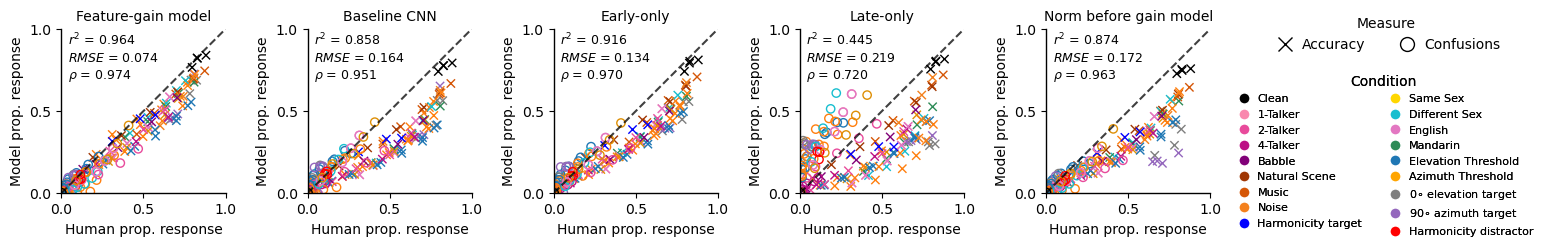

In [27]:
from matplotlib.lines import Line2D

reload(util_analysis)
combined_results['snr_condition_str'] = combined_results['snr'].astype(str) + ' dB ' + combined_results['background_condition']
human_results = combined_results[combined_results.group.str.contains('Human')]
human_results = human_results.sort_values(['snr', 'background_condition'])

model_order = util_analysis.model_name_order

human_model_sim_df = model_agg_sim_df.copy()

model_acc_r = []
model_conf_r = []
model_acc_rmse = []
model_conf_rmse = []

x = y = np.linspace(0,1,5)
fontsize = 10
aspect = 3

n_rows = 1
n_cols = len(model_order) + 1 

fig, axs = plt.subplots(n_rows, n_cols, 
                        figsize=((aspect * n_cols),
                        aspect*n_rows))

line_width=2

for j in range(len(model_order)):
    axs[j].plot(x,y, ls='dashed', color='k', alpha=0.75)

vert_spacing = 0.1 
conf_max_y = 0.8

conditions = list(palette.keys())


acc_colors = [palette[cond] for cond in human_results.background_condition.values]
conf_colors = [confusion_palette[cond] for cond in human_results.background_condition.values]



for ix, model in enumerate(model_order):
    if model == 'Feature-gain Model':
        fba_to_plot = combined_results[combined_results.group.str.contains('Feature')].groupby(['snr', 'background_condition']).agg({'accuracy': ['mean', 'sem'], 'confusions':['mean', 'sem']}).reset_index()
        fba_to_plot.columns = ['snr', 'background_condition', 'accuracy', 'acc_sem', 'confusions', 'conf_sem']
        fba_to_plot['snr_condition_str'] = fba_to_plot['snr'].astype(str) + ' dB ' + fba_to_plot['background_condition']

        fba_to_plot['group'] = 'Feature-gain Model'
        model_results = fba_to_plot.sort_values(['snr', 'background_condition'])
    else:
        model_results = combined_results[combined_results.model == model]
        model_results = model_results.sort_values(['snr', 'background_condition'])

    axs[ix].scatter(x=human_results.accuracy, y=model_results.accuracy,
                        marker='x', #alpha=0.5,
                        c=acc_colors,
                        linestyle='',
                        #   s=3,
                          )
    axs[ix].scatter(x=human_results.confusions, y=model_results.confusions,
                        marker='o', #alpha=0.5,
                        facecolors='none', edgecolors=conf_colors,
                        linestyle='',
                        #  s=3,
                        )
    
    
    axs[ix].set_title(model.replace("Model", 'model'), fontsize=fontsize)
    axs[ix].set_xlabel(f"Human prop. response", fontsize=fontsize)
    axs[ix].set_ylabel(f"Model prop. response", fontsize=fontsize)

    r2, rmse, rho  = human_model_sim_df.loc[human_model_sim_df.group == model, ['r2', 'rmse', 'rho']].values[0]

    ## Add stats 
    axs[ix].annotate(f"$r^2$ = {r2:.3f}", (0.04, 0.9), fontsize=fontsize-1)
    axs[ix].annotate(f"$RMSE$ = {rmse:.3f}", (0.04, 0.8), fontsize=fontsize-1)
    axs[ix].annotate(f"$\\rho$ = {rho:.3f}", (0.04, 0.7), fontsize=fontsize-1)


    # set first row x and y limits to 0 1
ticks = np.linspace(0,1,3).round(1)

for ax in axs.flat[:-1]:
    ax.set_xticks(ticks=ticks) # set new labels
    ax.set_xticklabels(labels=ticks,fontsize=fontsize) 
    ax.set_yticks(ticks=ticks) # set new labels
    ax.set_yticklabels(labels= ticks, fontsize=fontsize)
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(1)
        ax.spines[axis].set_color('k')

## add legend to last pannel for colors and marker shapes 
# Create legend for colors (experiment types)
color_legend_handles = [
    Line2D([0], [0], marker='o', color='w',
           label=cond,
           markerfacecolor=palette_for_legend[cond],
           markersize=8)
    for cond in lgnd_cond_order
]

# Create legend for marker shapes (measurement types)
shape_legend_handles = [
    Line2D([0], [0], marker='x', color='k', linestyle='',
           label='Accuracy', markersize=10),
    Line2D([0], [0], marker='o', color='k', linestyle='',
           markerfacecolor='none', label='Confusions', markersize=10),
]

axs[-1].axis('off')

# Create and add first legend (color legend)
color_legend = fig.legend(handles=color_legend_handles, title="Condition", frameon=False,
                              ncols=2,
                              # reduce space between marker and text 
                              handletextpad=0.25,
                              loc='upper left', fontsize=fontsize-2, title_fontsize=fontsize,
                              bbox_to_anchor=(0.77, 0.65),

                            #   bbox_transform=fig.transFigure
                              )       

# Manually add that legend back to the Axes after the next one overwrites it
axs[-1].add_artist(color_legend)

# Add second legend (shape legend)
fig.legend(handles=shape_legend_handles, title="Measure",  frameon=False,
               ncol=2,
               handletextpad=0.25,
               loc='lower left', fontsize=fontsize, title_fontsize=fontsize,
               bbox_to_anchor=(0.79, 0.65),
            #    bbox_transform=fig.transFigure

)

sns.despine()

plt.subplots_adjust(wspace=0.5)


for ax in axs.flat:
    ax.set(aspect='equal')
# plt.savefig(fig_out_dir / "figure_6_human_model_sim_scatter_w_norm_pre_gain.svg", bbox_inches='tight', transparent=True)


### Run mutual information analysis 

In [28]:
## silence future warnings 
import warnings
from importlib import reload
import src.mutual_information_analyzer as mi_package
reload(mi_package)
MutualInformationAnalyzer = mi_package.MutualInformationAnalyzer

warnings.filterwarnings("ignore", category=FutureWarning)

np.random.seed(42)
data_for_barplot = combined_results[~combined_results.model.str.contains('alt')].copy()
data_for_barplot.loc[data_for_barplot['group'].str.contains("Human"), 'group'] = 'Human'  


melted_for_errbars = pd.melt(data_for_barplot, id_vars=['snr', 'background_condition', 'group'], value_vars=['accuracy', 'confusions'], var_name='metric', value_name='measure').reset_index(drop=True)
melted_for_errbars['condition_string'] = melted_for_errbars['snr'].astype(str) + ' dB ' + melted_for_errbars['background_condition'] + ' ' + melted_for_errbars['metric']

melted_for_errbars = melted_for_errbars.sort_values(['condition_string'])

model_list = [model for model in melted_for_errbars.group.unique() if 'Human' not in model]

unique_conds = melted_for_errbars.condition_string.unique()
n_conditions = melted_for_errbars.condition_string.nunique()

model_agg_mi_records = []

n_boots = 1000

full_human_measure = melted_for_errbars[melted_for_errbars.group == 'Human'].sort_values(['condition_string']).measure.values

analyzer = MutualInformationAnalyzer()

bins = [5, 10 ,15 ,20]

for model in tqdm(model_list):
    model_measure = melted_for_errbars[melted_for_errbars.group == model].sort_values(['condition_string']).measure.values
    for bin_size in tqdm(bins, desc=f"Bins for {model}", leave=False):
        mi, ci_lower, ci_upper, sem = analyzer.bootstrap_mi_confidence(full_human_measure,
                                        model_measure,
                                        n_bootstrap=n_boots,
                                        method='discrete',
                                        n_bins=bin_size,
                                        binning_method='uniform')


        record = {
            'group': model,
            'mi': mi,
            'mi_ci': [ci_lower, ci_upper],
            'm_sem': sem,
            'n_bins': bin_size
        }
        model_agg_mi_records.append(record)

model_mi_sim_df = pd.DataFrame.from_records(model_agg_mi_records)      

  0%|          | 0/5 [00:00<?, ?it/s]

Bins for Feature-gain Model:   0%|          | 0/4 [00:00<?, ?it/s]

Bins for Late-only:   0%|          | 0/4 [00:00<?, ?it/s]

Bins for Baseline CNN:   0%|          | 0/4 [00:00<?, ?it/s]

Bins for Early-only:   0%|          | 0/4 [00:00<?, ?it/s]

Bins for Norm before gain model:   0%|          | 0/4 [00:00<?, ?it/s]

['Feature-gain model',
 'Baseline CNN',
 'Early-only',
 'Late-only',
 'Norm before gain model']

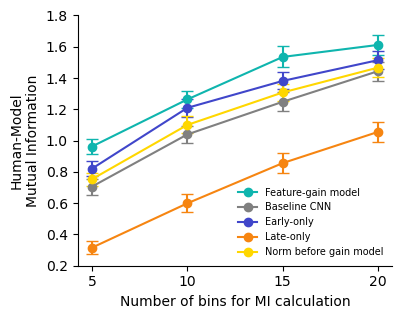

In [29]:
to_plot = model_mi_sim_df.copy()
## add bar plot 
aspect = 3.25
fontsize = 10

fig, ax = plt.subplots(figsize=(aspect*1.25, aspect))


model_order = deepcopy(util_analysis.model_name_order)
model_colors = deepcopy(util_analysis.model_color_dict)


for model in model_order:
    model_data = to_plot[to_plot.group == model].sort_values('n_bins')
    x = model_data.n_bins.values
    y = model_data.mi.values
    y_err = model_data.m_sem.values
    ax.errorbar(x, y,
                yerr=y_err,
                label=model,
                color=model_colors[model],
                # alpha=0.7,
                fmt='-o',
                capsize=4)
ax.set_xlabel("Number of bins for MI calculation", fontsize=fontsize)
ax.set_ylabel("Human-Model\nMutual Information", fontsize=fontsize)
ax.set_ylim(0.2,1.8)
ax.set_xticks(np.arange(5, 21, 5))
# ax.legend(fontsize=fontsize-2, title_fontsize=fontsize, handletextpad=0.25, frameon=False)
handles, labels = ax.get_legend_handles_labels()

# Modify handles to remove lines from errorbar legend entry
new_handles = []
for h in handles:
    if isinstance(h, container.ErrorbarContainer):
        new_handles.append(h[0])  # Append only the marker (Line2D)
    else:
        new_handles.append(h)

# # Create legend with modified handles
labels[0] = labels[0].replace("M", 'm')
ax.legend(new_handles, labels, fontsize=fontsize-3,  frameon=False)#, bbox_to_anchor=(0.8, 0.4))
sns.despine()
# plt.savefig(fig_out_dir / "sup_fig_12_human_model_mutual_information.pdf", transparent=True, bbox_inches='tight')
labels

## Plot review rebuttal for figure 6 - alt model v main model

In [31]:
np.random.seed(0)
data_for_barplot = combined_results[~combined_results.model.str.contains('alt')].copy()
data_for_barplot.loc[data_for_barplot['group'].str.contains("Human"), 'group'] = 'Human'  


melted_for_errbars = pd.melt(data_for_barplot, id_vars=['snr', 'background_condition', 'group'], value_vars=['accuracy', 'confusions'], var_name='metric', value_name='measure').reset_index(drop=True)
melted_for_errbars['condition_string'] = melted_for_errbars['snr'].astype(str) + ' dB ' + melted_for_errbars['background_condition'] + ' ' + melted_for_errbars['metric']


melted_for_errbars = melted_for_errbars.sort_values(['condition_string'])


In [32]:
def get_human_model_sim_metrics(human_sample, model_sample):
    r, _ = stats.pearsonr(human_sample, model_sample)
    r2 = r ** 2
    rmse = np.sqrt(np.mean((human_sample - model_sample) ** 2))
    rho = stats.spearmanr(human_sample, model_sample).statistic
    return r2, rmse, rho

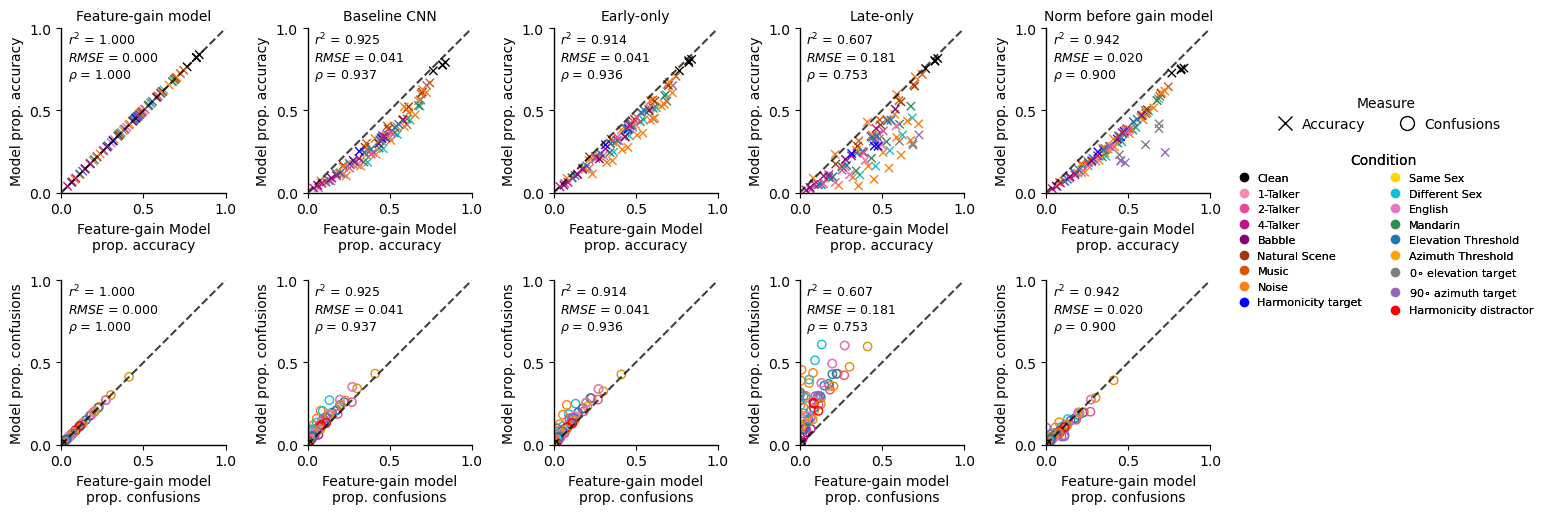

In [ ]:
from matplotlib.lines import Line2D

reload(util_analysis)
combined_results['snr_condition_str'] = combined_results['snr'].astype(str) + ' dB ' + combined_results['background_condition']

fba_to_plot = combined_results[combined_results.group.str.contains('Feature')].groupby(['snr', 'background_condition']).agg({'accuracy': ['mean', 'sem'], 'confusions':['mean', 'sem']}).reset_index()
fba_to_plot.columns = ['snr', 'background_condition', 'accuracy', 'acc_sem', 'confusions', 'conf_sem']
fba_to_plot['snr_condition_str'] = fba_to_plot['snr'].astype(str) + ' dB ' + fba_to_plot['background_condition']

fba_to_plot['group'] = 'Feature-gain Model'
main_model_results = fba_to_plot.sort_values(['snr', 'background_condition'])


model_order = util_analysis.model_name_order

model_acc_r = []
model_conf_r = []
model_acc_rmse = []
model_conf_rmse = []

x = y = np.linspace(0,1,5)
fontsize = 10
aspect = 3

n_rows = 2
n_cols = len(model_order) + 1 

fig, axs = plt.subplots(n_rows, n_cols, 
                        figsize=((aspect * n_cols), (aspect*n_rows)))

line_width=2

for i, ax in enumerate(axs.flat):
    if i % n_cols != n_cols - 1:
        ax.plot(x,y, ls='dashed', color='k', alpha=0.75)

vert_spacing = 0.1 
conf_max_y = 0.8

conditions = list(palette.keys())


acc_colors = [palette[cond] for cond in human_results.background_condition.values]
conf_colors = [confusion_palette[cond] for cond in human_results.background_condition.values]


for ix, model in enumerate(model_order):
    if model == 'Feature-gain Model':
        fba_to_plot = combined_results[combined_results.group.str.contains('Feature')].groupby(['snr', 'background_condition']).agg({'accuracy': ['mean', 'sem'], 'confusions':['mean', 'sem']}).reset_index()
        fba_to_plot.columns = ['snr', 'background_condition', 'accuracy', 'acc_sem', 'confusions', 'conf_sem']
        fba_to_plot['snr_condition_str'] = fba_to_plot['snr'].astype(str) + ' dB ' + fba_to_plot['background_condition']

        fba_to_plot['group'] = 'Feature-gain Model'
        model_results = fba_to_plot.sort_values(['snr', 'background_condition'])
    else:
        model_results = combined_results[combined_results.model == model]
        model_results = model_results.sort_values(['snr', 'background_condition'])

    axs[0, ix].scatter(x=main_model_results.accuracy, y=model_results.accuracy,
                        marker='x', #alpha=0.5,
                        c=acc_colors,
                        linestyle='',
                        #   s=3,
                          )
    # make Model lower case in title 
    axs[0, ix].set_title(model.replace("Model", 'model'), fontsize=fontsize)
    axs[0, ix].set_xlabel(f"Feature-gain Model\nprop. accuracy", fontsize=fontsize)
    axs[0, ix].set_ylabel(f"Model prop. accuracy", fontsize=fontsize)
    r2, rmse, rho = get_human_model_sim_metrics(main_model_results.confusions.values, model_results.confusions.values)

    ## Add stats 
    axs[0, ix].annotate(f"$r^2$ = {r2:.3f}", (0.04, 0.9), fontsize=fontsize-1)
    axs[0, ix].annotate(f"$RMSE$ = {rmse:.3f}", (0.04, 0.8), fontsize=fontsize-1)
    axs[0, ix].annotate(f"$\\rho$ = {rho:.3f}", (0.04, 0.7), fontsize=fontsize-1)


    axs[1, ix].scatter(x=main_model_results.confusions, y=model_results.confusions,
                        marker='o', #alpha=0.5,
                        facecolors='none', edgecolors=conf_colors,
                        linestyle='',
                        #  s=3,
                        )
    axs[1, ix].set_xlabel(f"Feature-gain model\nprop. confusions", fontsize=fontsize)
    axs[1, ix].set_ylabel(f"Model prop. confusions", fontsize=fontsize)
    r2, rmse, rho = get_human_model_sim_metrics(main_model_results.confusions.values, model_results.confusions.values)

    ## Add stats 
    axs[1, ix].annotate(f"$r^2$ = {r2:.3f}", (0.04, 0.9), fontsize=fontsize-1)
    axs[1, ix].annotate(f"$RMSE$ = {rmse:.3f}", (0.04, 0.8), fontsize=fontsize-1)
    axs[1, ix].annotate(f"$\\rho$ = {rho:.3f}", (0.04, 0.7), fontsize=fontsize-1)

    



    # set first row x and y limits to 0 1
ticks = np.linspace(0,1,3).round(1)

for ax in axs.flat[:-1]:
    ax.set_xticks(ticks=ticks) # set new labels
    ax.set_xticklabels(labels=ticks,fontsize=fontsize) 
    ax.set_yticks(ticks=ticks) # set new labels
    ax.set_yticklabels(labels= ticks, fontsize=fontsize)
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(1)
        ax.spines[axis].set_color('k')

## add legend to last pannel for colors and marker shapes 
# Create legend for colors (experiment types)
color_legend_handles = [
    Line2D([0], [0], marker='o', color='w',
           label=cond,
           markerfacecolor=palette_for_legend[cond],
           markersize=8)
    for cond in lgnd_cond_order
]

# Create legend for marker shapes (measurement types)
shape_legend_handles = [
    Line2D([0], [0], marker='x', color='k', linestyle='',
           label='Accuracy', markersize=10),
    Line2D([0], [0], marker='o', color='k', linestyle='',
           markerfacecolor='none', label='Confusions', markersize=10),
]

axs[0,-1].axis('off')
axs[1,-1].axis('off')

# Create and add first legend (color legend)
color_legend = fig.legend(handles=color_legend_handles, title="Condition", frameon=False,
                              ncols=2,
                              # reduce space between marker and text 
                              handletextpad=0.25,
                              loc='upper left', fontsize=fontsize-2, title_fontsize=fontsize,
                              bbox_to_anchor=(0.77, 0.65),

                            #   bbox_transform=fig.transFigure
                              )       

# Manually add that legend back to the Axes after the next one overwrites it
axs[0, -1].add_artist(color_legend)

# Add second legend (shape legend)
fig.legend(handles=shape_legend_handles, title="Measure",  frameon=False,
               ncol=2,
               handletextpad=0.25,
               loc='lower left', fontsize=fontsize, title_fontsize=fontsize,
               bbox_to_anchor=(0.79, 0.65),
            #    bbox_transform=fig.transFigure

)

sns.despine()

plt.subplots_adjust(wspace=0.5)


for ax in axs.flat:
    ax.set(aspect='equal')
# plt.savefig(fig_out_dir / "sup_fig_14_model_v_feature_gain_model_scatter.svg", transparent=True, bbox_inches='tight')
